In [1]:
import os
import pandas as pd
from datetime import datetime

def phase_wise_analysis(df, corr_col, ramp_col, coil_length_col, threshold=0.7, window_size=250):
    if df[ramp_col].max() <= 15:
        return []

    norm_val = df[ramp_col].mode()[0]
    norm_df = df[df[ramp_col] == norm_val]
    if norm_df.empty:
        return []

    phase1_end = norm_df.index[0]
    phase2_end = norm_df.index[-1]

    # Define dataframes for each phase
    phase1_df = df.iloc[:phase1_end + 1]
    phase2_df = df.iloc[phase1_end:phase2_end + 1]
    phase3_df = df.iloc[phase2_end + 1:]

    results = []
    for phase_df, phase_name in zip([phase1_df, phase2_df, phase3_df], ['Phase 1', 'Phase 2', 'Phase 3']):
        corr_series = phase_df[corr_col].iloc[window_size - 1:].dropna()
        total = len(corr_series)
        significant = (corr_series.abs() >= threshold).sum()
        contribution = (significant / total) if total > 0 else 0
        avg_corr = corr_series[abs(corr_series) >= threshold].abs().mean() if significant > 0 else 0

        results.append((phase_name, total, significant, contribution, avg_corr))
    return results


import pandas as pd

def get_coils_of_years(file_path, year):
    xls = pd.ExcelFile(file_path)
    pickle_id_lists = []

    df = pd.read_excel(xls, sheet_name="All Data")
    if 'Pickle ID' in df.columns and 'Coil_Prod_Date' in df.columns:
        # Convert dates and filter rows by year
        df['Coil_Prod_Date'] = pd.to_datetime(df['Coil_Prod_Date'], errors='coerce')
        filtered_df = df[df['Coil_Prod_Date'].dt.year == year]
        pickle_id_lists.extend(filtered_df['Pickle ID'].dropna().astype(int).tolist())

    return set(pickle_id_lists)


def process_file_phase_wise(file_path, signal_features, shape_features, coil_length_col, year_coils, ramp_col='Master Ramp', threshold=0.7, window_size=250):
    df = pd.read_csv(file_path)
    coil_id = df['Coil ID'].iloc[0]
    # folder_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))  # Get parent folder name
    # coil_type, grade = folder_name.split(" ")

    all_results = []
    
    if(coil_id in year_coils):
        for signal in signal_features:
            for shape in shape_features:
                corr_col = f"{signal}_Rolling_Corr_{shape}"
                if corr_col not in df.columns:
                    print(f"{corr_col} not in file")
                    continue
    
                phase_stats = phase_wise_analysis(df, corr_col, ramp_col, coil_length_col, threshold, window_size)
                for phase_name, total, significant, contribution, avg_corr in phase_stats:
                    all_results.append({
                        "Coil ID": coil_id,
                        "Phase": phase_name,
                        # "Coil Type": coil_type,
                        # "Grade": grade,
                        "Signal Feature": signal,
                        "Shape Feature": shape,
                        "Total Windows": total,
                        "Significant Correlation Window Count": significant,
                        "Contribution Factor %": f"{contribution * 100:.4f}",
                        "Average Correlation": avg_corr
                    })
    
    return all_results


def process_single_folder_phasewise(folder_path, signal_features, shape_features, coil_length_col, ramp_col='Master Ramp', threshold=0.7, window_size=250,year=2025):
    cnt = 0
    all_results = []
    coil_year = year
    year_coils = get_coils_of_years(r"D:\Stelco\Work\Dynamic Correlation\QVW Data for S&R 2024-7-2025 - 1008GCQ.xlsx",year)
    files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    print(f"\nProcessing folder: {folder_path} | Total files: {len(files)}\nNo of coils of {year}:- {len(year_coils)}")
    start_time = datetime.now()

    file_names_set = {int(f.split(".")[0]) for f in files}

    for coil_id in year_coils:
        if coil_id not in file_names_set:  # checking whether it is in folder
            print(f"Skipping {coil_id} — not found in folder")
            continue

        cnt += 1
        file_path = os.path.join(folder_path, f"{coil_id}.csv")
        print(f"{cnt}. Processing file: {coil_id}")

        results = process_file_phase_wise(file_path, signal_features, shape_features, coil_length_col, year_coils, ramp_col, threshold, window_size)
        all_results.extend(results)

        # if(cnt==100):
        #     break

    print(f"Finished processing folder: {folder_path} | Time taken: {datetime.now() - start_time}")

    final_df = pd.DataFrame(all_results)
    final_df["Contribution Factor %"] = final_df["Contribution Factor %"].astype(float)

    # checking 5% for Phase 1 and Phase 3 and 3% for Phase 2
    final_df = final_df[
        ((final_df['Phase'] == 'Phase 1') & (final_df['Contribution Factor %'] > 5)) |
        ((final_df['Phase'] == 'Phase 3') & (final_df['Contribution Factor %'] > 5)) |
        ((final_df['Phase'] == 'Phase 2') & (final_df['Contribution Factor %'] > 3))
    ]

    final_output = f"Phasewise_correlation_summary_for_{year}_coils_(3% Phase2).csv"
    final_df.to_csv(final_output, index=False)
    print(f"\nSummary saved to: {final_output}")

# === INPUT PARAMETERS ===

coil_types = r"D:\Stelco\Work\Dynamic Correlation\Key\Master Whole Phase"

In [2]:
signal_features = ['X4 Gauge Deviation',
              'Master Ramp', 'Stand 1 Gap Operator Offset', 'Stand 2 Gap Operator Offset',
                 'Stand 3 Gap Operator Offset', 'Stand 4 Gap Operator Offset', 'S1 Operating Bending Trim', 'S2 Operating Bending Trim',
                 'S3 Operating Bending Trim', 'S4 Operating Bending Trim',
               'X0 Gauge Deviation', 'X1 Gauge Deviation',
               'Stand 1-2 Tension Reference', 'Stand 2-3 Tension Reference', 'Stand 3-4 Tension Reference', 'Stand 1-2 Total Tension Feedback',
                 'Stand 2-3 Total Tension Feedback', 'Stand 3-4 Total Tension Feedback', 'Exit Tension Reel Tension Reference',
                 'Tension Reel Calculated Tension', 'Stand 1 Gap Bite Offset', 'Stand 1 Gap Stick Offset', 'Stand 1 Gap Thread Offset',
                 'Stand 1 Thread Gap Setpoint', 'Stand 1 Run Gap Setpoint', 'Stand 2 Gap Bite Offset', 'Stand 2 Gap Stick Offset',
                 'Stand 2 Gap Thread Offset', 'Stand 2 Thread Gap Setpoint', 'Stand 2 Run Gap Setpoint', 'Stand 3 Gap Bite Offset',
                 'Stand 3 Gap Stick Offset', 'Stand 3 Gap Thread Offset', 'Stand 3 Thread Gap Setpoint', 'Stand 3 Run Gap Setpoint',
                 'Stand 4 Gap Bite Offset', 'Stand 4 Gap Stick Offset', 'Stand 4 Gap Thread Offset', 'Stand 4 Thread Gap Setpoint',
                 'Stand 4 Run Gap Setpoint', 'Stand 1 Predicted Run Force', 'Stand 2 Predicted Run Force', 'Stand 3 Predicted Run Force',
                 'Stand 4 Predicted Run Force', 'Stand 1 - Total Force', 'Stand 2 - Total Force', 'Stand 2 - Total Force', 'Stand 2 - Total Force',
                 'Stand 1 Top Current Feedback', 'Stand 2 Top Current Feedback', 'Stand 3 Top Current Feedback', 'Stand 4 Top Current Feedback',
                 'Stand 1 Bottom Current Feedback', 'Stand 2 Bottom Current Feedback', 'Stand 3 Bottom Current Feedback', 'Stand 4 Bottom Current Feedback',
                 'Master Ramp', 'AGC GE Feedforward Hardness Number', 'AGC Alex Dynamic Feedforward Hardness Number', 'Stand 1 Total Bending Feedback',
                 'Stand 2 Total Bending Feedback', 'Stand 3 Total Bending Feedback', 'Stand 4 OS Total Bending Feedback', 'Stand 4 DS Total Bending Feedback', 'Stand 1 - Operator Side Force', 
                 'Stand 1 - Drive Side Force', 'Stand 2 - Operator Side Force', 'Stand 2 - Drive Side Force', 'Stand 3 - Operator Side Force',  'Stand 3 - Drive Side Force', 
                 'Stand 4 - Operator Side Force', 'Stand 4 - Drive Side Force', 'Stand 1-2 Total Tension Feedback', 'Stand 2-3 Total Tension Feedback', 'Stand 3-4 Total Tension Feedback',
                 'Stand 1 Drive Speed Feedback', 'Stand 2 Drive Speed Feedback', 'Stand 3 Drive Speed Feedback', 'Stand 4 Drive Speed Feedback',
               'Neet Oil Concentration', 'Stand 1-3 Solution Temperature', 'Stand 1-3 Solution System Pressure',
                 'Stand 4 Solution System Pressure', 'Stand 1 Gap Eccentricity Trim', 'Stand 2 Gap Eccentricity Trim',
                 'Stand 3 Gap Eccentricity Trim', 'Stand 4 Gap Eccentricity Trim', 'Morgoil OperBottom Bearing Outflow Temp Stand1',
                 'Morgoil OperTop Bearing Outflow Temp Stand1', 'Morgoil DriveBottom Bearing Outflow Temp Stand1',
                 'Morgoil DriveTop Bearing Outflow Temp Stand1', 'Morgoil OperBottom Bearing Outflow Temp Stand2',
                 'Morgoil OperTop Bearing Outflow Temp Stand2', 'Morgoil DriveBottom Bearing Outflow Temp Stand2',
                 'Morgoil DriveTop Bearing Outflow Temp Stand2', 'Morgoil OperBottom Bearing Outflow Temp Stand3',
                 'Morgoil OperTop Bearing Outflow Temp Stand3', 'Morgoil DriveBottom Bearing Outflow Temp Stand3',
                 'Morgoil DriveTop Bearing Outflow Temp Stand3', 'Morgoil OperBottom Bearing Outflow Temp Stand4',
                 'Morgoil OperTop Bearing Outflow Temp Stand4', 'Morgoil DriveBottom Bearing Outflow Temp Stand4',
                 'Morgoil DriveTop Bearing Outflow Temp Stand4']

shape_features = ["Operator_Q_VW_OLD_OPTECH","Q1_Q_VW_OLD_OPTECH","Center_Q_VW_OLD_OPTECH","Q2_Q_VW_OLD_OPTECH","Driver_Q_VW_OLD_OPTECH"] 

coil_length_col = "Coil Length [30ms]"

In [3]:
# === RUN THE SCRIPT ===
# process_folders_phasewise(coil_types, signal_features, shape_features, coil_length_col) #modify = read every sheet in loop
process_single_folder_phasewise(coil_types, signal_features, shape_features, coil_length_col) #modify = read every sheet in loop


Processing folder: D:\Stelco\Work\Dynamic Correlation\Key\Master Whole Phase | Total files: 2988
No of coils of 2025:- 1167
1. Processing file: 5507074
2. Processing file: 5484557
3. Processing file: 5484559
4. Processing file: 5507089
5. Processing file: 5484561
6. Processing file: 5505041
7. Processing file: 5500954
8. Processing file: 5500955
9. Processing file: 5490716
10. Processing file: 5500958
11. Processing file: 5490720
12. Processing file: 5505057
13. Processing file: 5507109
14. Processing file: 5492783
15. Processing file: 5496879
16. Processing file: 5500977
17. Processing file: 5482545
18. Processing file: 5486643
19. Processing file: 5500981
20. Processing file: 5486648
21. Processing file: 5496888
22. Processing file: 5490748
23. Processing file: 5500989
24. Processing file: 5486657
25. Processing file: 5500994
26. Processing file: 5500995
27. Processing file: 5500998
28. Processing file: 5501001
29. Processing file: 5514808
30. Processing file: 5510331
31. Processing

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_1936\166111644.py:51: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


305. Processing file: 5507651
306. Processing file: 5499463
307. Processing file: 5489223
308. Processing file: 5505609
309. Processing file: 5489226
310. Processing file: 5505613
311. Processing file: 5489230
312. Processing file: 5513807
313. Processing file: 5499471
314. Processing file: 5505619
315. Processing file: 5489237
316. Processing file: 5497431
317. Processing file: 5491290
318. Processing file: 5497435
319. Processing file: 5487197
320. Processing file: 5489245
321. Processing file: 5497440
322. Processing file: 5489249
323. Processing file: 5487203
324. Processing file: 5497444
325. Processing file: 5487205
326. Processing file: 5489253
327. Processing file: 5497447
328. Processing file: 5491302
329. Processing file: 5505641
330. Processing file: 5491306
331. Processing file: 5489257
332. Processing file: 5489260
333. Processing file: 5491309
334. Processing file: 5499500
335. Processing file: 5497453
336. Processing file: 5495407
337. Processing file: 5501552
338. Proce

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def generate_heatmap(df, grade, shape_features_to_include=None):
    # Step 1: Count total unique coils
    total_unique_coils = df['Coil ID'].nunique()
    print(f"Total coils of grade {grade} : {total_unique_coils}")

    # Step 2: Filter rows with contribution above 5% (Phase 1 and Phase 3) & above 3% (Phase 2)
    # df = df[df["Contribution Factor %"] > 5]
    df = df[
    ((df['Phase'] == 'Phase 1') & (df['Contribution Factor %'] > 5)) |
    ((df['Phase'] == 'Phase 3') & (df['Contribution Factor %'] > 5)) |
    ((df['Phase'] == 'Phase 2') & (df['Contribution Factor %'] > 3))
]
    total_unique_coils = df['Coil ID'].nunique()
    print(f"Total coils of grade {grade} showing contribution above 5% : {total_unique_coils}")

    for phase in df["Phase"].unique():
        phase_df = df[df["Phase"] == phase]
        total_unique_coils = phase_df['Coil ID'].nunique()
        print(f"Total coils of grade {grade} showing contribution above 5% in {phase} : {total_unique_coils}")

        # Step: Save filtered Phase 2 data for a specific Signal-Shape pair
        if phase == "Phase 2":
            target_signal = "Stand 1-3 Solution Temperature"
            target_shape = "Driver_Q_VW_OLD_OPTECH"
            
            subset_pair_df = phase_df[
                (phase_df['Signal Feature'] == target_signal) &
                (phase_df['Shape Feature'] == target_shape)
            ]
            
            if not subset_pair_df.empty:
                subset_pair_df.to_csv(f"Filtered_Phase2_SignalShapePair_{target_signal}_vs_{target_shape}.csv", index=False)
                print(f"Saved filtered Phase 2 data for ({target_signal}, {target_shape}) with {len(subset_pair_df)} rows.")
            else:
                print(f"No data found for ({target_signal}, {target_shape}) in Phase 2.")
    
        # Step 3: Count unique Coil IDs for each Signal-Shape pair
        grouped = phase_df.groupby(['Signal Feature', 'Shape Feature'])['Coil ID'].nunique().reset_index()

        # Optional: filter to include only selected Shape Features
        if shape_features_to_include:
            grouped = grouped[grouped['Shape Feature'].isin(shape_features_to_include)]
        
        # Step 4: Calculate percentage
        grouped['Percentage'] = (grouped['Coil ID'] / total_unique_coils) * 100

        grouped['Shape Feature'] = grouped['Shape Feature'].apply(lambda x: x.split("_")[0]+"_"+x.split("_")[1]+x.split("_")[2])  # split by space
        
        # Step 5: Pivot for heatmap
        heatmap_data = grouped.pivot(index='Signal Feature', columns='Shape Feature', values='Percentage').fillna(0)

        
        # Filter: At least 3 shape features > 2%
        heatmap_data = heatmap_data[heatmap_data.gt(2).sum(axis=1) >= 2]
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': '% of Unique Coils'})
        plt.title(f'Heatmap of % Unique Coils per Signal-Shape Feature Combination | {phase} | {grade} | {total_unique_coils}')
        plt.xlabel('Shape Features')
        plt.ylabel('Signal Features')
        plt.tight_layout()
        plt.savefig(f"heatmap_percentage_{phase}.png", dpi=300)
        plt.show()

Total coils of grade 1008GCQ : 1089
Total coils of grade 1008GCQ showing contribution above 5% : 1089
Total coils of grade 1008GCQ showing contribution above 5% in Phase 3 : 931


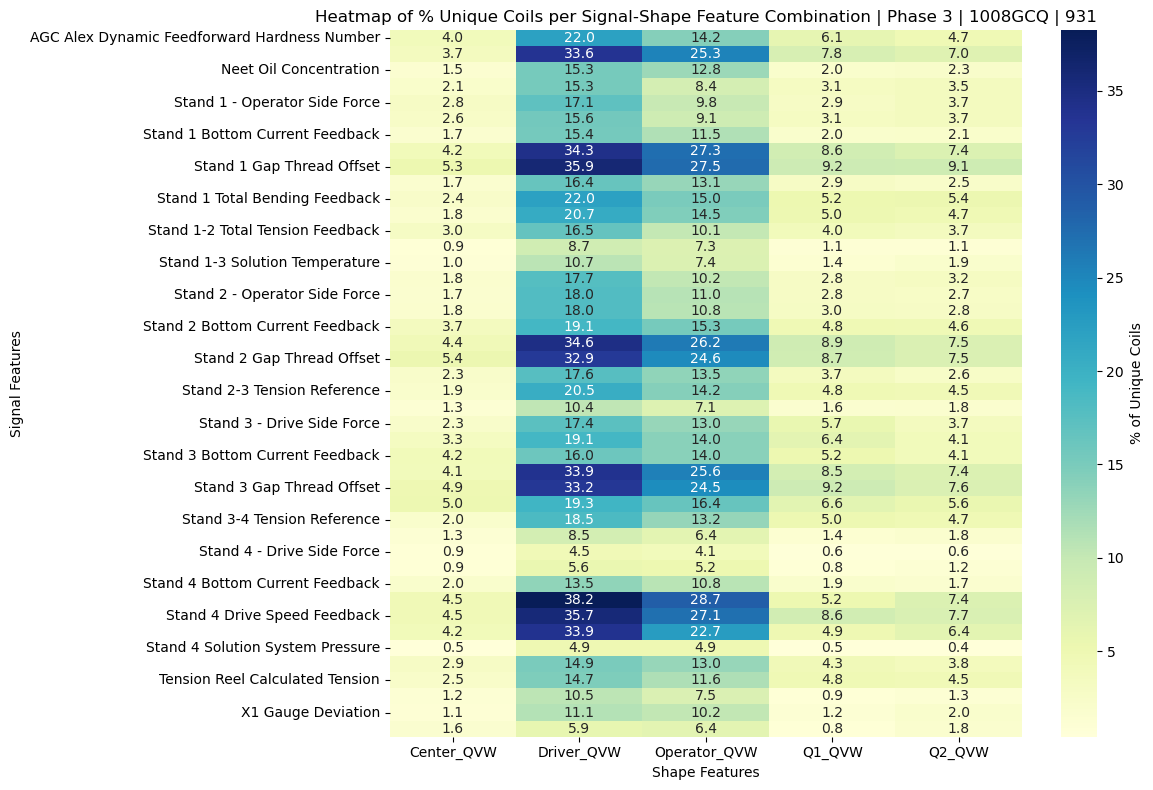

Total coils of grade 1008GCQ showing contribution above 5% in Phase 2 : 278
Saved filtered Phase 2 data for (Stand 1-3 Solution Temperature, Driver_Q_VW_OLD_OPTECH) with 48 rows.


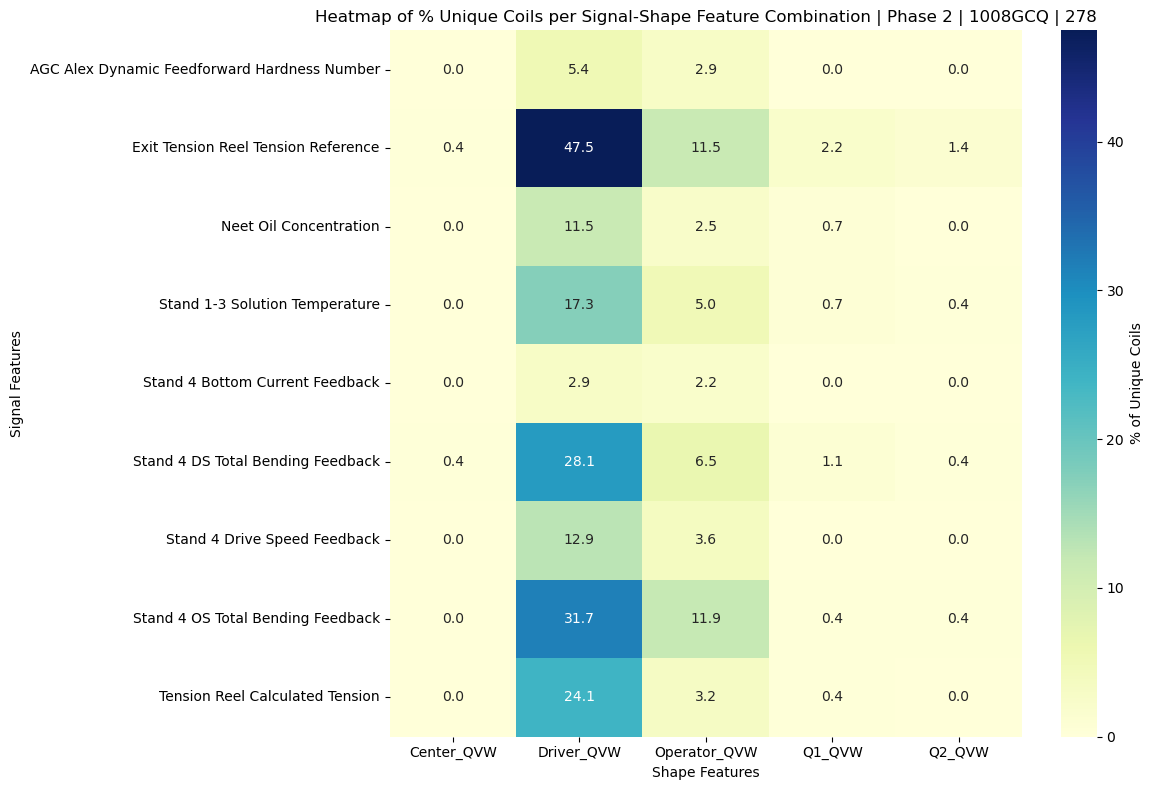

Total coils of grade 1008GCQ showing contribution above 5% in Phase 1 : 493


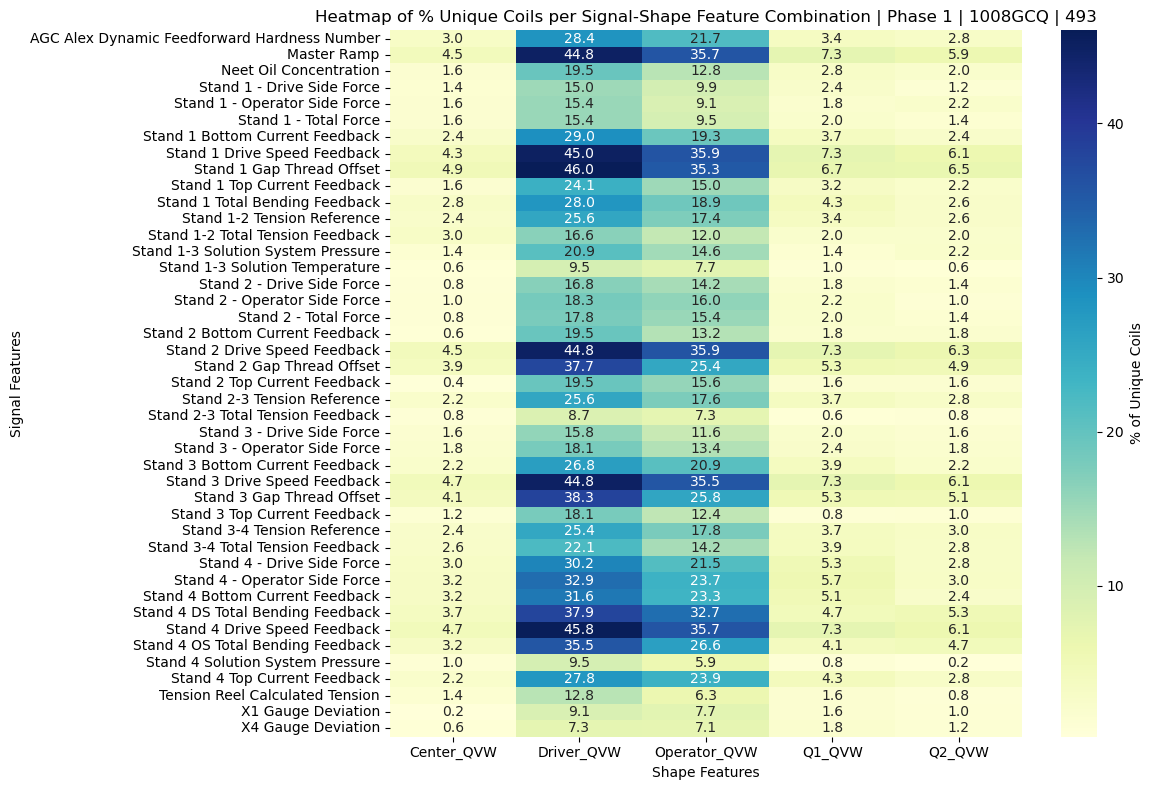

In [18]:
df = pd.read_csv("Phasewise_correlation_summary_for_all_bad_Q_VW_coils_(3% Phase2).csv")
generate_heatmap(df,"1008GCQ",shape_features)

In [10]:
file_path = r"D:\Stelco\Work\Dynamic Correlation\QVW Data for S&R 2024-7-2025 - 1008GCQ.xlsx"
xls = pd.ExcelFile(file_path)

# Initialize a dictionary to hold lists from each sheet
pickle_id_lists = {}

# Loop through sheets except "All Data"
for sheet_name in xls.sheet_names:
    if sheet_name != "All Data":
        df = pd.read_excel(xls, sheet_name=sheet_name)
        # Extract Pickle Ids as list and store it
        if 'Pickle ID' in df.columns:
            pickle_id_lists[sheet_name] = df['Pickle ID'].dropna().tolist()

# Merge all lists and convert to a set for unique values
all_unique_ids = set()
for ids in pickle_id_lists.values():
    all_unique_ids.update(ids)

# return all_unique_ids
print(all_unique_ids)
print("\nNo of Bad Coils:- ",len(all_unique_ids))

for i in all_unique_ids:
    if i==None:
        print("Yes")

{5483009, 5508614, 5508616, 5483016, 5514763, 5501454, 5433358, 5510677, 5510679, 5437977, 5510683, 5444637, 5444641, 5510690, 5437985, 5510181, 5510696, 5510699, 5469227, 5510701, 5455916, 5438514, 5435443, 5434419, 5510709, 5456950, 5466167, 5510713, 5508153, 5438521, 5510717, 5479998, 5449279, 5516352, 5486143, 5499458, 5507651, 5510724, 5486148, 5454403, 5505604, 5442119, 5440581, 5431882, 5459023, 5513807, 5512276, 5486165, 5491801, 5486171, 5436508, 5434461, 5484124, 5500512, 5444193, 5477986, 5506659, 5512291, 5434471, 5512297, 5489260, 5495407, 5488239, 5514353, 5508210, 5504116, 5508214, 5504118, 5451382, 5501049, 5485179, 5501052, 5512319, 5431937, 5512324, 5505668, 5458566, 5431942, 5508232, 5431945, 5488266, 5512330, 5431949, 5512335, 5488272, 5436049, 5450898, 5501586, 5431954, 5431958, 5499542, 5436056, 5512346, 5431962, 5502109, 5514911, 5453985, 5501092, 5506724, 5493414, 5479082, 5483693, 5436590, 5431982, 5477555, 5509300, 5439671, 5438649, 5510331, 5483196, 5436604, 

In [25]:
list1 = [
    5483009, 5508614, 5508616, 5483016, 5514763, 5501454, 5433358, 5510677, 5510679,
    5437977, 5510683, 5444637, 5444641, 5510690, 5437985, 5510181, 5510696, 5510699,
    5469227, 5510701, 5455916, 5438514, 5435443, 5434419, 5510709, 5456950, 5466167,
    5510713, 5508153, 5438521, 5510717, 5479998, 5449279, 5516352, 5486143, 5499458,
    5507651, 5510724, 5486148, 5454403, 5505604, 5442119, 5440581, 5431882, 5459023,
    5513807, 5512276, 5486165, 5491801, 5486171, 5436508, 5434461, 5484124, 5500512,
    5444193, 5477986, 5506659, 5512291, 5434471, 5512297, 5489260, 5495407, 5488239,
    5514353, 5508210, 5504116, 5508214, 5504118, 5451382, 5501049, 5485179, 5501052,
    5512319, 5431937, 5512324, 5505668, 5458566, 5431942, 5508232, 5431945, 5488266,
    5512330, 5431949, 5512335, 5488272, 5436049, 5450898, 5501586, 5431954, 5431958,
    5499542, 5436056, 5512346, 5431962, 5502109, 5514911, 5453985, 5501092, 5506724,
    5493414, 5479082, 5483693, 5436590, 5431982, 5477555, 5509300, 5439671, 5438649,
    5510331, 5483196, 5436604, 5514942, 5439677, 5454527, 5510338, 5480132, 5452997,
    5454533, 5514952, 5510345, 5514442, 5501646, 5453007, 5439694, 5436625, 5436627,
    5453012, 5510355, 5510360, 5484248, 5453018, 5451483, 5454554, 5447903, 5499618,
    5454563, 5477607, 5508842, 5440747, 5432044, 5454570, 5477614, 5448433, 5458162,
    5436659, 5436663, 5500154, 5477638, 5481225, 5448969, 5454605, 5458190, 5454608,
    5499153, 5463827, 5502740, 5458195, 5492503, 5506329, 5454618, 5499164, 5491996,
    5474081, 5505826, 5507365, 5489959, 5442856, 5478701, 5454640, 5437237, 5511490,
    5508420, 5440839, 5451591, 5500236, 5453644, 5454673, 5512535, 5454682, 5458780,
    5514081, 5514593, 5511019, 5458802, 5442419, 5511028, 5511026, 5465977, 5431675,
    5485439, 5459327, 5507458, 5482888, 5441941, 5476760, 5515162, 5497243, 5515166,
    5431710, 5508003, 5515173, 5515686, 5502377, 5481385, 5514668, 5454764, 5515182,
    5481391, 5514674, 5476413, 5514677, 5481398, 5500859, 5505470, 5508543, 5440447,
    5482431, 5504450, 5436867, 5477829, 5431752, 5446602, 5482442, 5479372, 5495245,
    5446607, 5500879, 5516242, 5454846, 5478871, 5508568, 5478873, 5486554, 5436892,
    5498336, 5476833, 5503968, 5464546, 5447653, 5503973, 5501415, 5484522, 5436396,
    5478894, 5466608, 5454320, 5436917, 5509110, 5451257, 5483006
]


list2 = [
    5431675, 5431710, 5431937, 5431942, 5431945, 5431949, 5431954, 5431958, 5431962, 5431982,
    5432044, 5433358, 5434471, 5435443, 5436049, 5436056, 5436396, 5436508, 5436590, 5436604,
    5436625, 5436627, 5436659, 5436663, 5436867, 5437237, 5437977, 5437985, 5438514, 5438521,
    5438649, 5439671, 5439694, 5440447, 5440581, 5440747, 5440839, 5442419, 5442856, 5444193,
    5444641, 5448433, 5448969, 5449279, 5451382, 5451483, 5451591, 5452997, 5453007, 5453012,
    5453018, 5453644, 5453985, 5454320, 5454403, 5454527, 5454533, 5454554, 5454563, 5454570,
    5454605, 5454608, 5454618, 5454640, 5454673, 5454682, 5454764, 5455916, 5456950, 5458190,
    5458195, 5458566, 5463827, 5464546, 5465977, 5466167, 5466608, 5469227, 5474081, 5477555,
    5477607, 5477614, 5477638, 5477986, 5478871, 5478873, 5478894, 5479372, 5479998, 5480132,
    5481225, 5481385, 5481391, 5482431, 5482442, 5482888, 5483006, 5483009, 5483016, 5483196,
    5483693, 5484124, 5484248, 5484522, 5485179, 5485439, 5486143, 5486148, 5486165, 5486171,
    5488239, 5488266, 5488272, 5489959, 5491801, 5492503, 5493414, 5498336, 5499164, 5499458,
    5500236, 5500512, 5500859, 5500879, 5501049, 5501052, 5501092, 5501415, 5501454, 5501586,
    5501646, 5502109, 5502377, 5502740, 5503968, 5503973, 5504118, 5505668, 5505826, 5506329,
    5506659, 5507365, 5507458, 5507651, 5508003, 5508210, 5508232, 5508420, 5508543, 5508568,
    5508614, 5508616, 5508842, 5509110, 5509300, 5510181, 5510338, 5510345, 5510355, 5510677,
    5510679, 5510683, 5510690, 5510696, 5510699, 5510701, 5510709, 5510713, 5510717, 5510724,
    5511019, 5511026, 5511028, 5511490, 5512276, 5512319, 5512330, 5512335, 5512346, 5513807,
    5514353, 5514442, 5514593, 5514668, 5514674, 5514763, 5514942, 5514952, 5515162, 5515173,
    5515182, 5515686, 5516242
]

missing_in_list2 = list(set(list1) - set(list2))
print("Items in list1 but not in list2:", missing_in_list2)

Items in list1 but not in list2: [5512324, 5499153, 5450898, 5441941, 5499542, 5476760, 5497243, 5491996, 5444637, 5515166, 5514911, 5506724, 5479082, 5478701, 5434419, 5514677, 5481398, 5508153, 5510331, 5439677, 5476413, 5505470, 5516352, 5504450, 5505604, 5477829, 5442119, 5431752, 5431882, 5446602, 5495245, 5459023, 5446607, 5512535, 5510360, 5486554, 5458780, 5434461, 5436892, 5447903, 5514081, 5499618, 5512291, 5476833, 5447653, 5512297, 5489260, 5495407, 5458162, 5458802, 5504116, 5436917, 5508214, 5451257, 5500154, 5454846, 5459327]


In [24]:
len(list2)

250

## 